In [1]:
import os
import sys
sys.path.append(os.path.abspath('/home/not-naive-bayes-MIL'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

from dataset import load_metaflow_myeloma_data, load_metaflow_myeloma_rep_data
from not_naive_bayes import KernelBayesMIL
from utils import radar_plot, ridgeline_plot

import json

sns.set_style('whitegrid')
%matplotlib inline

### Load data

In [2]:
parquet_path = '/mnt/metaflow_myeloma/'
X, Y, Z = load_metaflow_myeloma_data(parquet_path)
# X, Y, Z = load_metaflow_myeloma_rep_data(parquet_path, diagmm_p_id=31)

INFO:root:Selected patients : [11 12 13 14 15 16 17 18 23 24 25 27 28 29 31 33 34 35 37 38 39 40 42 43
 45 46 48 49 51 52 53]


### Training

In [3]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z,
                                                                     train_size=0.7,
                                                                     stratify=Y,
                                                                     random_state=42)

In [4]:
ft_partition = {
    'Part1': [[0, 1], [2, 3, 4, 5, 6], [7]],
    'Part2': [[0, 1, 2, 3, 4, 5, 6], [7]],
    'Part3': [[0, 1, 2, 3, 4, 5, 6]]
}
hs=np.logspace(-3, 0, 300)
bs=1000
params = {'hs':hs, 'batch_size':bs}

model = KernelBayesMIL(ft_partition['Part3'], 
              train_grid_size=10000, 
              eval_size=10000, 
              random_state=23, 
              label_prior='not unif', 
              adapt_bw_select=False,
              **params
              )
model = model.fit(X_train, Y_train)

INFO:root:Fitting model for feature block 1 ...
/home/not-naive-bayes-MIL/not_naive_bayes.py:300: RuntimeWarning: divide by zero encountered in log
  ll = np.ma.masked_invalid(np.log(a) - np.log(n * (h**d) * np.power(2 * np.pi, d / 2)))


In [5]:
# On all the data
Y_scores = model.score(X)
criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + Y_scores[:,1] - Y_scores[:,0]
fpr, tpr, thresholds = roc_curve(Y, criterion_vals)
tau = thresholds[np.argmax(tpr[1:] - fpr[1:])+1]
print("Chosen threshold :", tau)
Y_pred = (criterion_vals >= tau).astype(int)
train_acc = np.mean(Y == Y_pred)
C = confusion_matrix(Y, Y_pred)
train_prec = C[1,1] / (C[1,1] + C[0,1]) if C[1,1] + C[0,1] > 0 else 0
train_rec = C[1,1] / (C[1,1] + C[1,0]) if C[1,1] + C[1,0] > 0 else 0
train_f1 = 2 * C[1,1] / (2 * C[1,1] + C[0,1] + C[1,0]) if C[1,1] + C[0,1] + C[1,0] > 0 else 0
train_auc = roc_auc_score(Y, Y_pred)
print(f"Training Acc : {train_acc:.2f}, Prec : {train_prec:.2f}, Rec : {train_rec:.2f}, F1 : {train_f1:.2f}, AUC : {train_auc:.2f}")

Chosen threshold : 4142.99828423858
Training Acc : 0.94, Prec : 0.95, Rec : 0.95, F1 : 0.95, AUC : 0.93


### Results viz and analysis

In [14]:
p_ids = np.array([11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 27, 28, 29, 31, 33, 34, 35, 37, 38, 39, 40, 42, 43,
 45, 46, 48, 49, 51, 52, 53], dtype=int)
markers = np.array(['FSC-A', 'SSC-A', 'CD45 V500-A', 'CD19 PerCP-Cy5.5-A', 'CD56 BV786-A', 'CD38 PE-Cy7-A', 'CD138 V450-A', 'H2 GFP-A'], dtype=str)

In [278]:
# Choose a random bag in th test set
target_class = 0
inds = np.flatnonzero((Y==target_class) & (Y_pred==target_class))
ind = inds[2] #np.random.choice(inds)
print(p_ids[ind])

16


In [279]:
X_i = X[ind] #X_test[ind]
Z_i = Z[ind] #Z_test[ind]

# contribution with loglikelihood ratio
x_contribs = model.get_instances_contrib(X_i)
x_contribs = x_contribs if Y_pred[ind]==1 else -x_contribs
sorted_instances = np.argsort(x_contribs)[::-1]
sorted_x_contribs = x_contribs[sorted_instances]
sorted_x_contribs[sorted_x_contribs==-np.inf] = 0
if Y_pred[ind] == 1:
    criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + sorted_x_contribs
    jjs = np.flatnonzero(criterion_vals >= tau)
    sorted_x_contribs[jjs] = 0
    criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + np.cumsum(sorted_x_contribs)
    top_inds = np.flatnonzero(criterion_vals >= tau)
    if len(top_inds)>0:
        j_min = np.min(top_inds)
        top_contrib_instances = np.append(sorted_instances[jjs], sorted_instances[:j_min+1])
    else:
        top_contrib_instances = sorted_instances[jjs].copy()
    # top_contrib_instances = sorted_instances[jjs].copy()
else:
    criterion_vals = np.log(1 - model.alpha_) - np.log(model.alpha_) + sorted_x_contribs
    jjs = np.flatnonzero(criterion_vals > 0)
    # sorted_x_contribs[jjs] = 0
    # criterion_vals = np.log(1 - model.alpha_) - np.log(model.alpha_) + np.cumsum(sorted_x_contribs)
    # top_inds = np.flatnonzero(criterion_vals > -tau)
    # if len(top_inds)>0:
    #     j_min = np.min(top_inds)
    #     top_contrib_instances = np.append(sorted_instances[jjs], sorted_instances[:j_min+1])
    # else:
    #     top_contrib_instances = sorted_instances[jjs].copy()
    top_contrib_instances = sorted_instances[jjs].copy()
    # top_contrib_instances = np.intersect1d(top_contrib_instances, np.flatnonzero(x_contribs>0))

# print("Self sufficient contribs :", x_contribs[sorted_instances[jjs]])
# print("Top essential contribs :", np.sort(x_contribs[top_contrib_instances]))

Top contrib Clusters ['B-cells' 'Others' 'PCA']


Text(0.5, 1.0, 'Predicted Y_i=0')

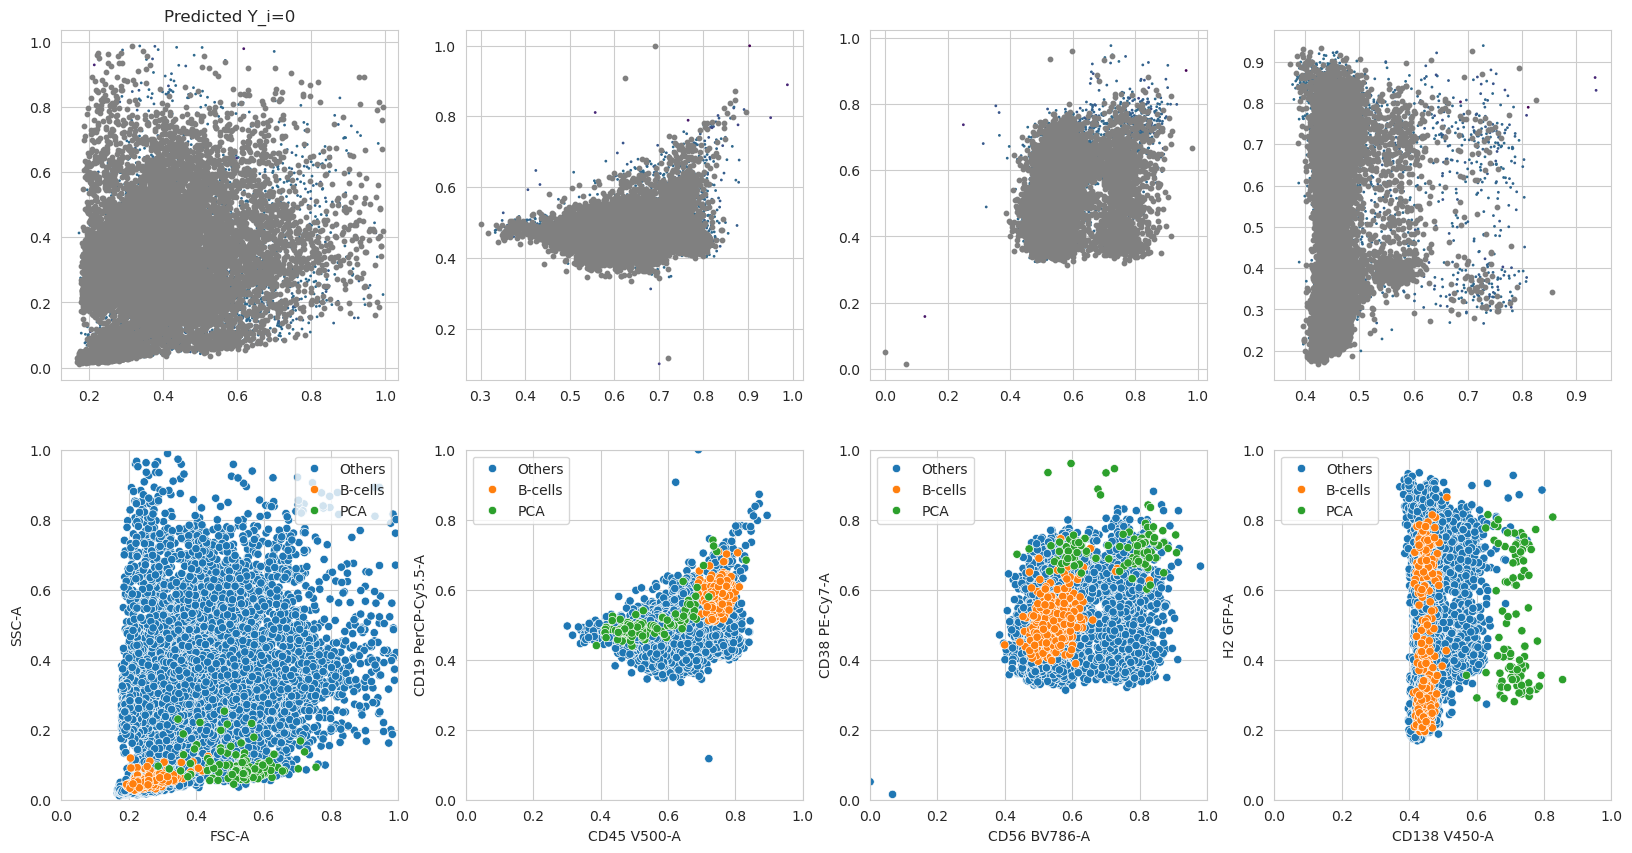

In [280]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# marker_sizes = 3 * np.ones(len(X_i))
# marker_sizes[x_contribs>0] = 15

isnotinf = ~np.isinf(x_contribs)
# top_contrib_instances = (x_contribs >= np.quantile(x_contribs, 0.9))

cluster_ids, counts = np.unique_counts(Z_i[top_contrib_instances])
event_to_cluster_count = pd.Series(Z_i[top_contrib_instances]).map(lambda k: counts[np.flatnonzero(cluster_ids==k)[0]]).to_numpy()
print(f"Top contrib Clusters {cluster_ids}")

for j in range(4):
    scatt_res = ax[0,j].scatter(X_i[isnotinf,2*j], X_i[isnotinf,2*j+1], c=x_contribs[isnotinf], cmap='viridis', s=1)
    ax[0,j].scatter(X_i[top_contrib_instances,2*j], X_i[top_contrib_instances,2*j+1], c='red' if Y_pred[ind]==1 else 'gray', s=10)
    ax[0,j].scatter(X_i[x_contribs==-np.inf,2*j], X_i[x_contribs==-np.inf,2*j+1], 
                  c='black' if Y_pred[ind]==1 else 'darkred', marker='^', s=15)
    ax[0,j].scatter(X_i[x_contribs==np.inf,2*j], X_i[x_contribs==np.inf,2*j+1], 
                  c='darkred' if Y_pred[ind]==1 else 'black', marker='^', s=15)
    # ax[0,j].set_xlim(0,1)
    # ax[0,j].set_ylim(0,1)

inds = np.argsort(event_to_cluster_count)[::-1]
for j in range(4):
    # ax[1,j].scatter(X_i[top_contrib_instances,2*j][inds], X_i[top_contrib_instances,2*j+1][inds], s=5, c=Z_i[top_contrib_instances][inds], cmap='tab10')
    sns.scatterplot(x=X_i[top_contrib_instances,2*j][inds], y=X_i[top_contrib_instances,2*j+1][inds], 
                    hue=Z_i[top_contrib_instances][inds], palette='tab10', ax=ax[1,j])
    ax[1,j].set_xlabel(markers[2*j])
    ax[1,j].set_ylabel(markers[2*j+1])
    ax[1,j].set_xlim(0,1)
    ax[1,j].set_ylim(0,1)

ax[0,0].set_title(f"Predicted Y_i={Y_pred[ind]}")
# plt.colorbar(scatt_res, ax=ax[0,0])

### Spider plot

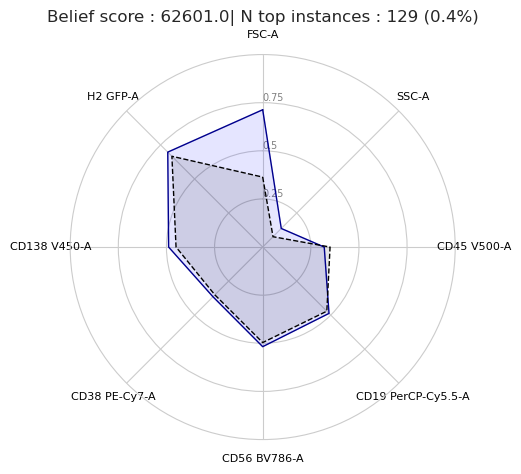

In [ ]:
notplasma_others_inds = np.flatnonzero(np.isin(Z_i, ['negPlasmo','Others']))
sub_top_contrib_instances = np.intersect1d(top_contrib_instances, notplasma_others_inds)

radar_plot(model, X_i, markers, top_contrib_instances, tau, color='darkblue')

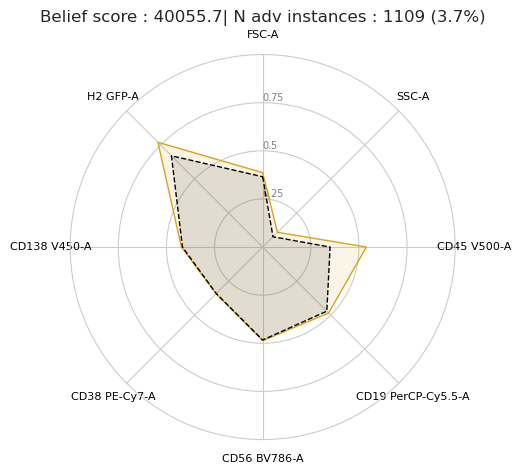

In [32]:
radar_plot(model, X_i, markers, top_contrib_instances, tau, advers=True, color='goldenrod')

### Ridgeline plot

In [48]:
with open('/home/data/myeloma_prognosis.json', 'r') as f:
            p_risks = json.load(f)

map_risks = {1.0:'Low', 2.0:'Medium', 3.0:'High', -1:'None'}

In [43]:
target_class = 1
inds = np.flatnonzero((Y==target_class) & (Y_pred==target_class))
selected_p_risks = np.array([p_risks.get(str(p_id), -1) for p_id in p_ids[inds]])
inds = inds[np.argsort(selected_p_risks)]

p_labels = []
for ind in inds:
    p_risk = p_risks.get(str(p_ids[ind]), -1)
    p_labels.append(map_risks.get(p_risk))

In [44]:
sub_X = []

for i in inds:
    X_i = X[i]
    x_contribs = model.get_instances_contrib(X_i)
    x_contribs = x_contribs if Y_pred[i]==1 else -x_contribs
    sorted_instances = np.argsort(x_contribs)[::-1]
    sorted_x_contribs = x_contribs[sorted_instances]
    sorted_x_contribs[sorted_x_contribs==-np.inf] = 0
    if Y_pred[i] == 1:
        criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + sorted_x_contribs
        jjs = np.flatnonzero(criterion_vals >= tau)
        sorted_x_contribs[jjs] = 0
        criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + np.cumsum(sorted_x_contribs)
        top_inds = np.flatnonzero(criterion_vals >= tau)
        if len(top_inds)>0:
            j_min = np.min(top_inds)
            top_contrib_instances = np.append(sorted_instances[jjs], sorted_instances[:j_min+1])
        else:
            top_contrib_instances = sorted_instances[jjs].copy()
    else:
        criterion_vals = np.log(1 - model.alpha_) - np.log(model.alpha_) + sorted_x_contribs
        jjs = np.flatnonzero(criterion_vals > 0)
        top_contrib_instances = sorted_instances[jjs].copy()
    sub_X.append(X_i[top_contrib_instances].copy())

In [ ]:
ridgeline_plot(sub_X, markers, 'H2 GFP-A', p_ids[inds], p_labels=p_labels, show_mean=True)